In [7]:
!pip install textstat
!pip install word2number
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import os
import glob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import itertools
import networkx as nx
from collections import Counter
from textblob import TextBlob

<div class="alert alert-block alert-success"> Historically, journalism has been dominated by male voices, often influencing the headlines, bylines, and the core narratives. But as times have evolved, more women have entered the scene, bringing fresh perspectives and challenging the status quo. Despite these strides, we're compelled to ask: Does an undercurrent of bias still prevail?<br>
    
To answer this, our EDA phase aims to draw distinctions between articles penned by male and female authors. We're curious: Are there noticeable differences in article lengths, the sentiments conveyed, the choice of pivotal words, or even the geographical regions highlighted? 

But it doesn't stop at just observations. We've ventured into predictive modeling, aiming to determine an author's gender purely based on their writing style and content. Here's where it gets interesting: if our model exhibits high accuracy, it might suggest that there are still distinct male and female "styles" in journalism. This ties back to our overarching question – in a field historically led by men, are the footprints of past biases still evident in today's narratives?

<div class="alert alert-block alert-success"> Using the os library to navigate through directories and read files. Reading in the Train and Test folders.

## Data Preprocessing

In [8]:
import os

def load_data(path):
    data = {}

    for author_dir in os.listdir(path):
        author_path = os.path.join(path, author_dir)
        
        if os.path.isdir(author_path):
            author_articles = []
            
            for filename in os.listdir(author_path):
                with open(os.path.join(author_path, filename), 'r', encoding='utf-8', errors='ignore') as file:
                    content = file.read()
                    author_articles.append(content)
            
            data[author_dir] = author_articles
    
    return data

# Load the training dataset using the load_data function.
train_data = load_data('ReutersC50/C50train')

# Load the testing dataset using the same function.
test_data = load_data('ReutersC50/C50test')

 <div class="alert alert-block alert-success"> The Reuters C50 data does not contain any information regarding the authors' genders but thanks to the fact that all 50 journalists in the dataset are well-known figures, we were able to map authors to gender using their name and a little bit of research.

In [9]:
# Create a dictionary to manually map authors to genders
author_gender_mapping = {
    'AaronPressman': 'male',
    'RobinSidel': 'female',
    'LynnleyBrowning': 'female',
    'KouroshKarimkhany': 'male',
    'MichaelConnor': 'male',
    'JoeOrtiz': 'male',
    'EricAuchard': 'male',
    'SimonCowell': 'male',
    "LynneO'Donnell": 'female',
    'EdnaFernandes': 'female',
    'KevinMorrison': 'male',
    'SamuelPerry': 'male',
    'PatriciaCommins': 'female',
    'JohnMastrini': 'male',
    'JanLopatka': 'male',
    'KevinDrawbaugh': 'male',
    'KarlPenhaul': 'male',
    'MartinWolk': 'male',
    'ScottHillis': 'male',
    'DavidLawder': 'male',
    'FumikoFujisaki': 'female',
    'MarcelMichelson': 'male',
    'NickLouth': 'male',
    'DarrenSchuettler': 'male',
    'WilliamKazer': 'male',
    'TanEeLyn': 'female',
    'PierreTran': 'male',
    'HeatherScoffield': 'female',
    'MureDickie': 'male',
    'RogerFillion': 'male',
    'JimGilchrist': 'male',
    'BradDorfman': 'male',
    'AlanCrosby': 'male',
    'JonathanBirt': 'male',
    'BenjaminKangLim': 'male',
    'TheresePoletti': 'female',
    'KeithWeir': 'male',
    'JoWinterbottom': 'female',
    'MarkBendeich': 'male',
    'JaneMacartney': 'female',
    'MatthewBunce': 'male',
    'ToddNissen': 'male',
    'PeterHumphrey': 'male',
    'TimFarrand': 'male',
    'SarahDavison': 'female',
    'GrahamEarnshaw': 'male',
    'BernardHickey': 'male',
    'KirstinRidley': 'female',
    'AlexanderSmith': 'male',
    'LydiaZajc': 'female'
}

<div class="alert alert-block alert-success"> Preprocessing the data in Train and Test before starting our analysis. This includes converting to lowercase, lemmatizing, removing stop words and making sure that alphanumeric characters are not included.<br>
Note that we have added additional stopwords to what is already provided by the nltk library.

In [10]:
# Download required resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    additional_stopwords = ["said", "mr", "mrs", "ms","also","new","year","would","one"]  # Additional stop words
    stop_words = set(stopwords.words('english') + additional_stopwords)
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words])

def preprocess_data(data):
    preprocessed_data = {}
    for author, articles in data.items():
        preprocessed_articles = [preprocess_text(article) for article in articles]
        preprocessed_data[author] = preprocessed_articles
    return preprocessed_data

train_data_prep = preprocess_data(train_data)
test_data_prep = preprocess_data(test_data)

[nltk_data] Downloading package punkt to /Users/barnana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/barnana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/barnana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<div class="alert alert-block alert-success"> Using the author_gender_mapping dictionary,we create labels for Train and Test data.

In [11]:
def convert_to_lists(data, gender_mapping):
    articles = []
    genders = []
    
    for author, author_articles in data.items():
        for article in author_articles:
            articles.append(article)
            genders.append(gender_mapping[author])
    
    return articles, genders

train_articles, train_labels = convert_to_lists(train_data_prep, author_gender_mapping)
test_articles, test_labels = convert_to_lists(test_data_prep, author_gender_mapping)

# Convert labels to 1 for female and 0 for male
train_labels = [1 if label == 'female' else 0 for label in train_labels]
test_labels = [1 if label == 'female' else 0 for label in test_labels]

<div class="alert alert-block alert-success"> Before we start our EDA, we are combining the Train and Test data because we want to perform EDA on the entire dataset not just Train.

In [12]:
# Combine articles
combined_articles = train_articles + test_articles

# Combine labels
combined_labels = train_labels + test_labels

print(len(combined_articles))  
print(len(combined_labels))    

5000
5000


## Exploratory Data Analysis

<div class="alert alert-block alert-success"> We're conducting exploratory data analysis (EDA) to find differences in articles written by male and female authors. This can reveal potential biases. Here, we'll search for bias evidence, and later, in the conclusion, discuss reasons for these findings.

<div class="alert alert-block alert-success"> 
<strong>1. Article Distribution by Gender:</strong><br>
Studying how articles are split between male and female authors helps us understand gender representation. If there's an uneven distribution, it might suggest biases in content or author demographics. This baseline is crucial for later comparisons. A balanced split shows fairness, while differences prompt a closer look for potential gender-related journalism biases.

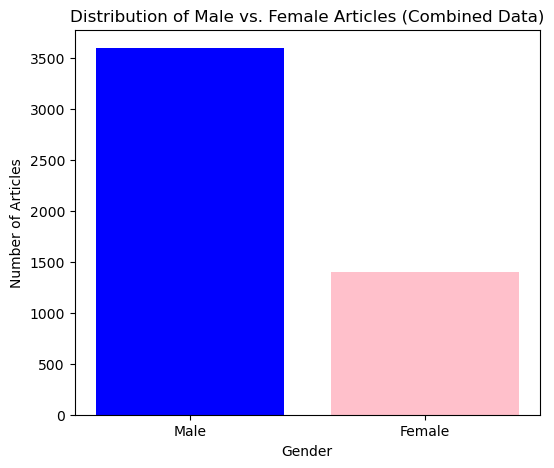

In [13]:
# Distribution of Male vs. Female Articles for Combined Data
combined_gender_counts = [combined_labels.count(0), combined_labels.count(1)]
labels = ['Male', 'Female']

plt.figure(figsize=(6, 5))
plt.bar(labels, combined_gender_counts, color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Number of Articles')
plt.title('Distribution of Male vs. Female Articles (Combined Data)')
plt.show()

<div class="alert alert-block alert-success"> The data reveals a significant disparity, with a disproportionately higher number of articles authored by men. In fact, articles written by women account for less than half of the total articles produced by their male counterparts. The notable difference in article contributions between genders hints at the presence of underlying biases that impact authorship opportunities and representation.

<div class="alert alert-block alert-success">
<strong>2. Word count distribution by Gender:</strong><br>
We examine word count patterns in articles by male and female authors to detect potential biases. Differences might indicate unequal content allocation, with longer male-authored articles possibly receiving more space or covering broader topics. Conversely, shorter female-authored articles could imply limited assignments. 

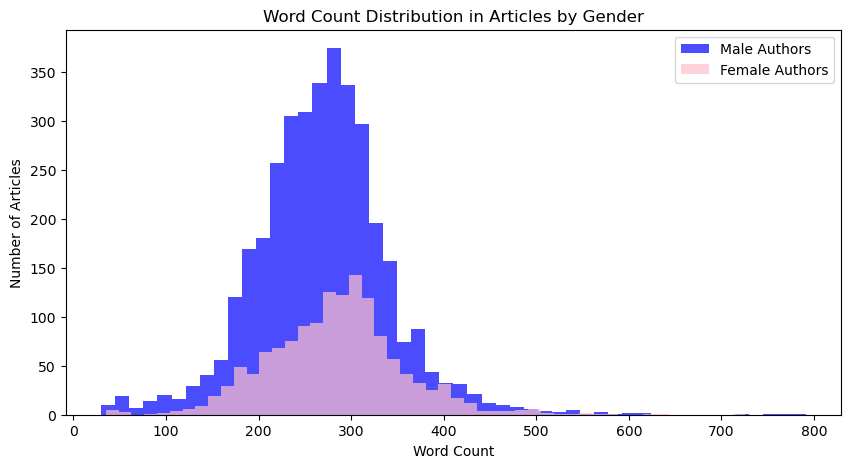

In [14]:
# Extracting word counts for articles written by male and female authors
male_word_counts = [len(article.split()) for i, article in enumerate(combined_articles) if combined_labels[i] == 0]
female_word_counts = [len(article.split()) for i, article in enumerate(combined_articles) if combined_labels[i] == 1]

# Plotting the distributions
plt.figure(figsize=(10, 5))

plt.hist(male_word_counts, bins=50, color='blue', alpha=0.7, label='Male Authors')
plt.hist(female_word_counts, bins=50, color='pink', alpha=0.7, label='Female Authors')

plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.title('Word Count Distribution in Articles by Gender')
plt.legend(loc='upper right')

plt.show()

<div class="alert alert-block alert-success">There does not appear to be a significant difference in terms of distribution for both genders. The histogram only looks starkly different because so many more articles are written by men. If we focus just on the distribution, it does not look very differently skewed for the two genders. The peaks and troughs of both distributions appear at roughly the same places. To confirm this, we will look at the average length of each article (in words) by gender next.

<div class="alert alert-block alert-success">
<strong>3. Average Article Length by Gender:</strong>
Analyzing average article length reveals potential gaps in content depth or assigned space for male and female authors. Based on what we observed in the histogram above, we do not expect to see a significant difference in average article length across the genders.

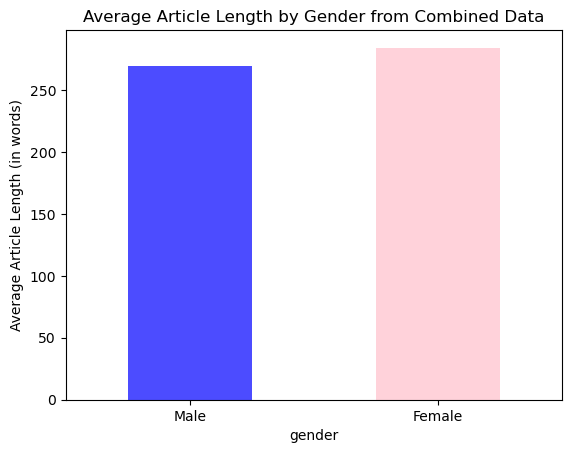

In [15]:
# Convert articles and labels from combined data to a dataframe
combined_df = pd.DataFrame({
    'article': combined_articles,
    'gender': combined_labels
})

# Compute the length of each article
combined_df['length'] = combined_df['article'].apply(lambda x: len(x.split()))

# Group by gender and compute average length
combined_avg_lengths = combined_df.groupby('gender')['length'].mean()

# Map the gender labels for visualization
gender_labels = {0: 'Male', 1: 'Female'}
combined_avg_lengths.index = combined_avg_lengths.index.map(gender_labels)

# Plot
combined_avg_lengths.plot(kind='bar', color=['blue', 'pink'], alpha=0.7)
plt.ylabel('Average Article Length (in words)')
plt.title('Average Article Length by Gender from Combined Data')
plt.xticks(rotation=0)
plt.show()

<div class="alert alert-block alert-success">As anticipated from the histogram shown earlier, there isn't a significant difference between the average article lengths for men and women. In fact, the average article length for female authors is slightly longer. This is good news! It challenges our initial hypothesis that there might be unequal content distribution and fewer assignments for female journalists.

<div class="alert alert-block alert-success">
<strong>4. Sentiment Distribution by Gender: </strong><br>
Sentiment analysis offers insights into the emotional tone and mood conveyed in articles. By comparing sentiment scores between male and female authors, we aim to identify if there exists a consistent, distinct tone associated with either gender. For instance, are articles by female authors generally more positive or negative compared to their male counterparts? This could indicate implicit biases or societal influences in how different genders approach topics, or it might reflect the kinds of assignments given to authors based on their gender. 

<div class="alert alert-block alert-success">Please note that the sentiment scores range from -1 to 1, with negative values indicating a negative sentiment, positive values indicating a positive sentiment, and values close to 0 suggesting neutral sentiment.

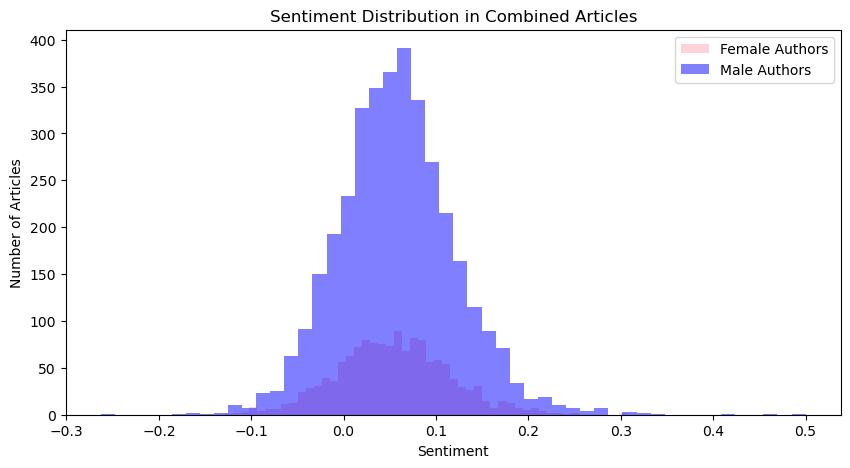

In [16]:
# Sentiment Analysis Distribution using combined data
combined_female_sentiments = [TextBlob(article).sentiment.polarity for i, article in enumerate(combined_articles) if combined_labels[i] == 1]
combined_male_sentiments = [TextBlob(article).sentiment.polarity for i, article in enumerate(combined_articles) if combined_labels[i] == 0]

plt.figure(figsize=(10, 5))
plt.hist(combined_female_sentiments, bins=50, color='pink', alpha=0.7, label='Female Authors')
plt.hist(combined_male_sentiments, bins=50, color='blue', alpha=0.5, label='Male Authors')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.title('Sentiment Distribution in Combined Articles')
plt.legend(loc='upper right')
plt.show()

<div class="alert alert-block alert-success">Similar to the word count distribution histogram, there does not appear to be a substantial difference in how male and female authors approach various subjects. If we focus purely on the distribution aspect of this histogram, it does not look very differently skewed for the two genders. It only looks starkly different because of the fact that men author a much larger number of articles. To confirm this, we will look at the average sentiment scores for each gender next.

<div class="alert alert-block alert-success">
<strong>5. Average Sentiment Scores by Gender: </strong><br>

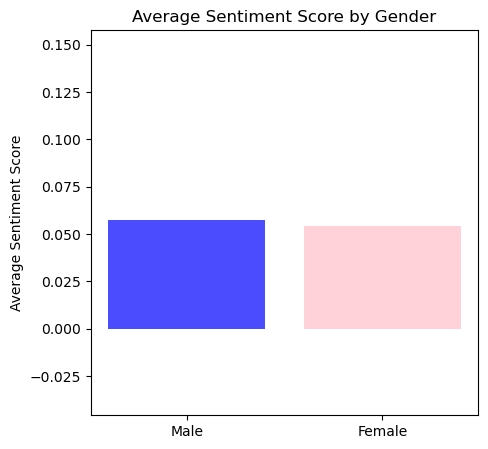

In [17]:
# Calculating the average sentiment scores for each gender
avg_female_sentiment = np.mean(combined_female_sentiments)
avg_male_sentiment = np.mean(combined_male_sentiments)

# Values and Labels for plotting
avg_sentiment_values = [avg_male_sentiment, avg_female_sentiment]
gender_labels = ['Male', 'Female']

# Plotting the averages
plt.figure(figsize=(5, 5))
plt.bar(gender_labels, avg_sentiment_values, color=['blue', 'pink'], alpha=0.7)
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score by Gender')
plt.ylim(min(avg_sentiment_values) - 0.1, max(avg_sentiment_values) + 0.1)
plt.show()

<div class="alert alert-block alert-success">As expected, there are no systematic differences in tone across genders. Both genders seem to approach their respective subjects with similar degrees of positivity. This also means that there is no evidence to back up our initial suspicion that topics might be assigned to journalists on the basis of their gender.

<div class="alert alert-block alert-success">
<strong>6. Mention of Numbers and Statistics:</strong><br>
Our goal is to examine if there are gender-related differences in the use of data-driven arguments in articles.
We use a function that scans each article's content to identify and tally various quantitative components:<br>
    
 - Explicit numeric values
 - Numeric words like "million","percent","hundred", etc.
 - Specific data-related terms such as "correlation","growth","chart", etc.
 - Numeric words that are transformed into actual numbers using the word2number library 

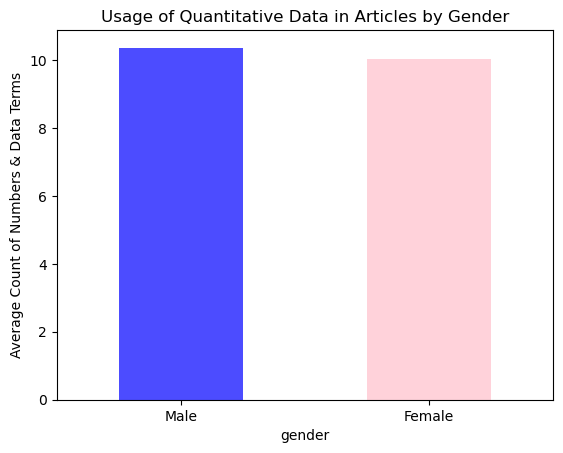

In [18]:
from word2number import w2n
import re

# Function to find numbers in articles
def count_numbers(text):
    count = 0
    words = text.split()
    
    # Counting explicit numeric values
    count += len(re.findall(r'\b\d+\b', text))
    
    # Counting numeric words & specific terms
    data_terms = ["million", "billion", "percent", "trillion", "thousand", "hundred", "ratio", "fraction", "average",
              "median", "mode", "standard deviation", "variance", "p-value", "correlation", "statistic", "probability", 
              "sample", "population", "study", "survey", "research", "analysis", "dataset", "figure", "table", 
              "chart", "graph", "percentage", "increase", "decrease", "growth", "trend", "rate", "measure", "estimate", 
              "projection"]

    for word in words:
        if word.lower() in data_terms:
            count += 1
        else:
            try:
                _ = w2n.word_to_num(word)
                count += 1
            except:
                continue
    return count

# Assuming combined_articles and combined_labels are your combined data
df = pd.DataFrame({
    'article': combined_articles,
    'gender': combined_labels
})

# Extract numbers using the function
df['num_count'] = df['article'].apply(count_numbers)

# Compute average count of numbers by gender
avg_num_counts = df.groupby('gender')['num_count'].mean()

# Map the gender labels for visualization
gender_labels = {0: 'Male', 1: 'Female'}
avg_num_counts.index = avg_num_counts.index.map(gender_labels)

# Plot
avg_num_counts.plot(kind='bar', color=['blue', 'pink'], alpha=0.7)
plt.ylabel('Average Count of Numbers & Data Terms')
plt.title('Usage of Quantitative Data in Articles by Gender')
plt.xticks(rotation=0)
plt.show()

<div class="alert alert-block alert-success">According to the bar plot above, no gender is more likely than the other to invoke numbers and statistics. This means that articles written by men and women are backed by similar levels of data and statistical analysis.

<div class="alert alert-block alert-success">
<strong>8. Average Readability Scores by Gender: </strong> <br> 
We aim to identify patterns in the writing complexity between male and female authors. If we notice a distinct difference in the average score between genders, it could hint at inherent disparities in writing styles or possibly the nature of topics each gender is covering. It's essential, however, to avoid jumping to conclusions. Differences in readability don't necessarily imply differences in content quality or depth. 

<div class="alert alert-block alert-success">The Flesch-Kincaid readability test is a tool that gauges the accessibility of written content. By assigning a numerical score, it reflects the ease (or challenge) of reading and understanding a text. Typically, a higher score suggests that the content is more straightforward and accessible, while a lower score indicates a more complex, demanding text.

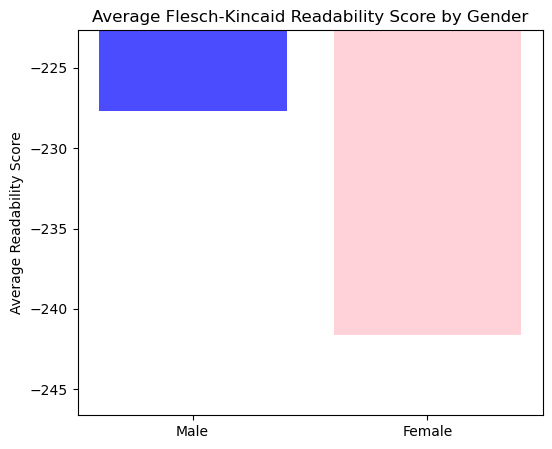

In [19]:
import textstat

# Using the combined articles and labels
female_readability = [textstat.flesch_reading_ease(article) for i, article in enumerate(combined_articles) if combined_labels[i] == 1]
male_readability = [textstat.flesch_reading_ease(article) for i, article in enumerate(combined_articles) if combined_labels[i] == 0]

# Calculating the average readability scores for each gender
avg_female_readability = np.mean(female_readability)
avg_male_readability = np.mean(male_readability)

# Values and Labels for plotting
avg_readability_values = [avg_male_readability, avg_female_readability]
gender_labels = ['Male', 'Female']

# Plotting the averages
plt.figure(figsize=(6, 5))
plt.bar(gender_labels, avg_readability_values, color=['blue', 'pink'], alpha=0.7)
plt.ylabel('Average Readability Score')
plt.title('Average Flesch-Kincaid Readability Score by Gender')
plt.ylim(min(avg_readability_values) - 5, max(avg_readability_values) + 5)  # Adjusting the y-axis limits for clarity
plt.show()

<div class="alert alert-block alert-success">From the barplot above, we can see that the distribution of readability scores are substantially different for male and female authors. The Readability score for female authors is much lower implying that female authors tend to write more complex articles that are more demanding of the reader.

<div class="alert alert-block alert-success">
<strong>9. Exploring Vocabulary Size by gender:</strong><br>
We measure the unique words used by male and female authors. A greater vocabulary might indicate a wider range of topics or a richer linguistic style.

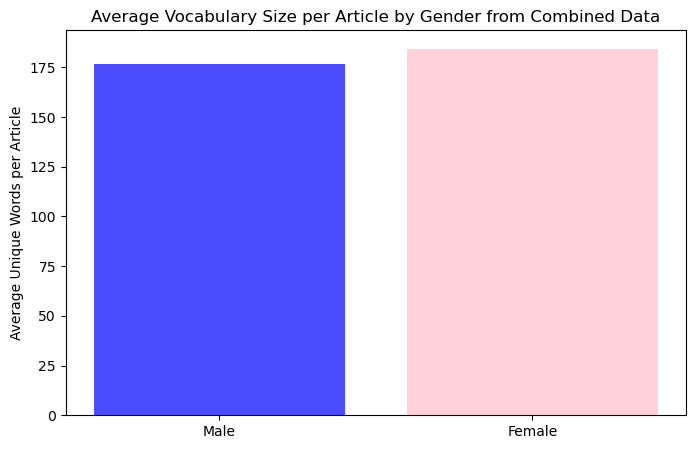

In [20]:
# Extract articles for each gender from the combined data
female_articles_combined = [article for i, article in enumerate(combined_articles) if combined_labels[i] == 1]
male_articles_combined = [article for i, article in enumerate(combined_articles) if combined_labels[i] == 0]

# Calculate average vocabulary size per article for each gender
female_avg_vocab_per_article = np.mean([len(set(article.split())) for article in female_articles_combined])
male_avg_vocab_per_article = np.mean([len(set(article.split())) for article in male_articles_combined])

# Values and Labels for plotting
avg_vocab_values = [male_avg_vocab_per_article, female_avg_vocab_per_article]
gender_labels = ['Male', 'Female']

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(gender_labels, avg_vocab_values, color=['blue', 'pink'], alpha=0.7)
plt.ylabel('Average Unique Words per Article')
plt.title('Average Vocabulary Size per Article by Gender from Combined Data')
plt.show()

<div class="alert alert-block alert-success"> The barplot above demonstrates no significant differences in vocabularies of male and female authors. This means that the number of unique words used per article, on an average, is almost the same for the two genders.

<div class="alert alert-block alert-success">
<strong>Conclusion from EDA:</strong><br>
The exploratory data analysis aimed to unveil any potential biases in journalism based on the gender of authors. The results paint a multifaceted picture. While there is a clear disparity in the number of articles written by male and female authors, suggesting a potential bias in authorship opportunities or representation, other metrics such as word count, sentiment, use of numbers and statistics, and vocabulary size show little to no difference between the genders. These observations indicate that, once given an opportunity, female authors contribute with similar depth, rigor, and linguistic richness as their male counterparts. However, the disparity in readability scores, with female authors tending to write more complex articles, hints at potential differences in writing styles or the nature of topics covered. Overall, while the initial distribution of articles suggests potential gender biases in journalistic opportunities, the content analysis largely dispels the notion of any systemic qualitative disparities in contributions between male and female authors.

## Predictive Model

<div class="alert alert-block alert-success">Now we move on to our predictive model where we will try to predict the gender of the author based on the contents of articles.

<div class="alert alert-block alert-success">
<strong>Feature Extraction:</strong><br>
In this code, we are processing the data by transforming unprocessed article texts into the following set of features can then serve as inputs for our machine learning model - <br>
    
 - Word Count
 - Average Word Length
 - Lexical Diversity (the ratio of unique words to the total number of words in the article)
 - Pronoun Usage
 - Frequency of the Top 50 Common Words 
 - Average Sentence Length 
 - Part-of-Speech (POS) Tagging: noun_count, verb_count, adj_count, adv_count
 - Passive Voice Usage 
 - Flesch Reading Ease Score

In [21]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
import textstat 

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def feature_extraction(texts):
    features = []
    
    for text in texts:
        feature = {}
        tokens = nltk.word_tokenize(text)
        sentences = nltk.sent_tokenize(text)
        pos_tags = pos_tag(tokens)
        
        # Total word count
        feature["word_count"] = len(tokens)
        
        # Average word length
        feature["avg_word_len"] = sum(len(word) for word in tokens) / len(tokens)
        
        # Lexical diversity
        feature["lexical_diversity"] = len(set(tokens)) / len(tokens)
        
        # Use of pronouns
        feature["pronoun_he"] = tokens.count("he")
        feature["pronoun_she"] = tokens.count("she")
        feature["pronoun_his"] = tokens.count("his")
        feature["pronoun_her"] = tokens.count("her")
        feature["pronoun_himself"] = tokens.count("himself")
        feature["pronoun_herself"] = tokens.count("herself")
        
        # Frequency of the top 50 common words
        common_words = [word for word, freq in Counter(" ".join(texts).split()).most_common(50)]
        for word in common_words:
            feature[f"word_freq_{word}"] = tokens.count(word)
        
        # Average sentence length
        feature["avg_sent_len"] = sum(len(nltk.word_tokenize(sent)) for sent in sentences) / len(sentences)
        
        # POS tagging
        feature["noun_count"] = sum(1 for word, pos in pos_tags if pos.startswith('N'))
        feature["verb_count"] = sum(1 for word, pos in pos_tags if pos.startswith('V'))
        feature["adj_count"] = sum(1 for word, pos in pos_tags if pos.startswith('J'))
        feature["adv_count"] = sum(1 for word, pos in pos_tags if pos.startswith('R'))
        
        # Passive voice usage
        feature["passive_voice"] = sum(1 for i in range(len(tokens) - 1) if tokens[i] == "was" or tokens[i] == "were" and tokens[i+1] in [word.name().split('.', 1)[0] for word in list(wn.all_synsets('v'))])
        
        # Flesch reading ease score
        feature["flesch_reading"] = textstat.flesch_reading_ease(text)
        
        features.append(feature)
    
    return features

# Extract features from the articles
X_train = feature_extraction(train_articles)
X_test = feature_extraction(test_articles)

[nltk_data] Downloading package punkt to /Users/barnana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/barnana/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<div class="alert alert-block alert-success"> We convert our feature dictionaries into vectors, fit a Random Forest model and print results.

<div class="alert alert-block alert-success"> We are addressing the class imbalance problem in our data through the class_weight parameter in the Random Forest classifier.<br>
With imbalanced data like ours, models might be biased towards the majority class. Class weights provide a mechanism to address class imbalance by assigning different importance levels to classes during the training of a machine learning model.By setting class weights, the model is "penalized" more for incorrectly predicting the minority class, making it more attentive to it. Specifically, when class weights are set to 'balanced', the weights are computed based on the inverse of class frequencies. This ensures that the minority class, despite being underrepresented, is given significant importance during training, leading to a more balanced and fair model.

In [22]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Convert feature dictionaries into feature vectors
vectorizer = DictVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']  # handle class imbalance
}

# Initialize the Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_vec, train_labels)

# Get the best estimator from the grid search
best_clf = grid_search.best_estimator_

# Predict on the test set using the best model
predicted_labels = best_clf.predict(X_test_vec)

# Evaluate the model's accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Display detailed classification report
report = classification_report(test_labels, predicted_labels)
print(report)

# Additionally, evaluate cross-validation score for the best model on the training data
cv_scores = cross_val_score(best_clf, X_train_vec, train_labels, cv=5)
print(f"Mean CV Score: {cv_scores.mean():.2f}")

Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1800
           1       0.78      0.21      0.33       700

    accuracy                           0.76      2500
   macro avg       0.77      0.60      0.60      2500
weighted avg       0.77      0.76      0.71      2500

Mean CV Score: 0.69


<div class="alert alert-block alert-success">
<strong>Results : </strong><br>
<strong>Overall Accuracy & Class Representation:</strong> The model achieved an overall accuracy of 76%. However, a closer look at class-specific metrics reveals a pronounced disparity in the model's performance between male and female authors.<br>

<strong>Male Author Detection:</strong>
The model exhibits a high recall of 98% for male authors. This indicates that the model correctly identifies 98% of the articles penned by male authors. Such a performance might stem from the fact that male-authored articles have a dominant presence in the dataset, leading the model to learn their characteristics more confidently.<br>

<strong>Female Author Detection:</strong>
The recall for female authors stands at a mere 21%. This metric underscores that, out of all the articles authored by females, the model correctly pinpoints them as female-authored only 21% of the time. Such a result is alarming and implies the model's difficulty in discerning articles written by females. On the brighter side, the model's precision for female authors is 78%, signifying that when the model does label an article as female-authored, it gets it right 78% of the time. Nevertheless, considering the low recall, it's evident that the model is overly cautious when predicting female authors, often missing out on several genuine instances. <br>
    
Furthermore, the mean cross-validation score of 0.69 suggests that, on average, the model's performance might vary across different partitions of the data, further emphasizing the need for more robust model tuning or feature engineering.

<div class="alert alert-block alert-success">
<strong>Next Steps : </strong><br>
To make the model better, we can do a few things. First, get more data, especially from female authors, to balance things out. We can also tweak the features, like looking at smaller language details or the article topics, to make the model sharper. Trying out fancier models or using a mix of them might make predictions more accurate. To prevent overfitting, we can use tricks to smooth out the model. 

<div class="alert alert-block alert-success">
<strong>Conclusion : </strong><br>
In conclusion, while some variations exist, they're not consistently reliable for accurately predicting an author's gender based solely on content. Individual differences, evolving language, context, and societal changes all contribute to this complexity. Therefore, gender prediction from writing should be approached with caution and awareness of the limitations and nuances involved.